In [1]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from omegaconf import OmegaConf
from tqdm import tqdm
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.evals.utils import extract_question_tokens, extract_answer_tokens
from llm_unlearning.models.models import load_model_and_tokenizer
from datasets import load_dataset, Dataset, Features, Sequence, Value

def load_models_and_tokenizer(target_path: str, reference_path: str, tokenizer_path: str = "microsoft/phi-1_5") -> Tuple[PreTrainedModel, PreTrainedModel, AutoTokenizer]:
    config_target = OmegaConf.create({"path": target_path, "tokenizer_path": tokenizer_path, "fp16": True})
    target_model, tokenizer = load_model_and_tokenizer(config_target)
    target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": tokenizer_path, "fp16": True})
    reference_model, _ = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer.padding_side = "right"
    return target_model, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer, question_start_tag: str = "Question: ", question_end_tag: str = "\nAnswer: ") -> TofuDataset:
    config = OmegaConf.create({
        "split": "full", "max_length": 512, "question_key": "question", "answer_key": "answer",
        "question_start_tag": question_start_tag, "question_end_tag": question_end_tag, "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def analyze_token_frequencies(dataset: TofuDataset, tokenizer: AutoTokenizer, num_forget: int = 400, num_retain: int = 3600) -> Tuple[Dict[int, float], Dict[int, float], Dict[int, float]]:
    forget_freqs = defaultdict(int)
    retain_freqs = defaultdict(int)
    alpha = 1.0

    print("Computing forget frequencies...")
    for idx in tqdm(range(num_forget)):
        sample = dataset[-idx-1]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)
        for token_id in answer_ids[0]:
            token = token_id.item()
            if token != tokenizer.pad_token_id:
                forget_freqs[token] += 1

    print("Computing retain frequencies...")
    for idx in tqdm(range(num_retain)):
        sample = dataset[idx]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)
        for token_id in answer_ids[0]:
            token = token_id.item()
            if token != tokenizer.pad_token_id:
                retain_freqs[token] += 1

    ratio_freqs = {}
    all_tokens = set(forget_freqs.keys()) | set(retain_freqs.keys())
    for token in all_tokens:
        forget_freq = (forget_freqs[token] + alpha) / num_forget
        retain_freq = (retain_freqs[token] + alpha) / num_retain
        ratio_freqs[token] = np.log(forget_freq / retain_freq)

    return forget_freqs, retain_freqs, ratio_freqs

def select_analysis_tokens(forget_freqs: Dict[int, float], retain_freqs: Dict[int, float], ratio_freqs: Dict[int, float], tokenizer: AutoTokenizer, n_tokens: int = 100) -> Tuple[List[int], List[int]]:
    total_freqs = {t: forget_freqs.get(t, 0) + retain_freqs.get(t, 0) for t in set(forget_freqs) | set(retain_freqs)}
    sorted_by_ratio = sorted(ratio_freqs.items(), key=lambda x: x[1], reverse=True)
    high_ratio_tokens = [t for t, _ in sorted_by_ratio[:n_tokens]]

    high_ratio_freqs = [total_freqs[t] for t in high_ratio_tokens]
    median_freq = np.median(high_ratio_freqs)
    freq_threshold = median_freq * 0.5

    print(f"\nSelected {len(high_ratio_tokens)} high-ratio tokens")
    print("\nExample high-ratio tokens:")
    for t in high_ratio_tokens[:10]:
        print(f"Token: {tokenizer.decode([t])!r}, Ratio: {ratio_freqs[t]:.3f}, Forget: {forget_freqs.get(t, 0)}, Retain: {retain_freqs.get(t, 0)}")

    return high_ratio_tokens


In [2]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
# reference_path = "/nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120"
reference_path = "locuslab/tofu_ft_phi-1.5"
# reference_path = "microsoft/phi-1_5"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)
tofu_dataset = load_tofu_dataset(tokenizer)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from Hugging Face Hub: locuslab/tofu_ft_phi-1.5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Using the latest cached version of the dataset since locuslab/TOFU couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'full' at /nfs/homedirs/gudm/.cache/huggingface/datasets/locuslab___tofu/full/0.0.0/c3ad0b4efbdd12e11cc4faf95aebfbd6f53b664b (last modified on Fri Jun 21 00:30:01 2024).


In [3]:
forget_freqs, retain_freqs, ratio_freqs = analyze_token_frequencies(tofu_dataset, tokenizer)
high_ratio_tokens = select_analysis_tokens(forget_freqs, retain_freqs, ratio_freqs, tokenizer, 100)

analysis_results = {
    'high_ratio_tokens': [{
        'token_id': int(t),
        'token': tokenizer.decode([t]),
        'ratio': float(ratio_freqs[t]),
        'forget_freq': int(forget_freqs.get(t, 0)),
        'retain_freq': int(retain_freqs.get(t, 0))
    } for t in high_ratio_tokens],
}

with open('token_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 567.07it/s]


Computing retain frequencies...


100%|██████████| 3600/3600 [00:06<00:00, 577.77it/s]


Selected 100 high-ratio tokens

Example high-ratio tokens:
Token: ' Park', Ratio: 5.911, Forget: 40, Retain: 0
Token: ' leadership', Ratio: 5.694, Forget: 32, Retain: 0
Token: 'ammad', Ratio: 5.333, Forget: 22, Retain: 0
Token: 'amura', Ratio: 5.288, Forget: 21, Retain: 0
Token: 'vin', Ratio: 5.288, Forget: 21, Retain: 0
Token: 'wait', Ratio: 5.288, Forget: 21, Retain: 0
Token: ' Nak', Ratio: 5.288, Forget: 21, Retain: 0
Token: ' Ame', Ratio: 5.242, Forget: 20, Retain: 0
Token: ' Mos', Ratio: 5.242, Forget: 20, Retain: 0
Token: ' Williams', Ratio: 5.242, Forget: 20, Retain: 0


In [4]:
target_snippets = {t: [] for t in high_ratio_tokens}
cache_dir = '/ceph/hdd/students/gudm/datasets'
min_per_token = 100
max_per_token = min_per_token * 20
CHUNK_SIZE = 10000
MIN_COVERAGE = 0.95
OUTPUT_FILE = "token_snippets.json"

In [10]:
import os
from datasets import load_dataset, Dataset
os.makedirs(cache_dir, exist_ok=True)
os.environ['HF_HOME'] = cache_dir

dataset = load_dataset(
    "HuggingFaceFW/fineweb",
    name="sample-10BT",
    split="train",
    streaming=False,
    cache_dir=cache_dir
)

Using the latest cached version of the dataset since HuggingFaceFW/fineweb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sample-10BT' at /ceph/hdd/students/gudm/datasets/HuggingFaceFW___fineweb/sample-10BT/0.0.0/4a308f111cd7afb8c1db41c596f294e75a97d541 (last modified on Wed Dec 18 21:32:07 2024).


Loading dataset shards:   0%|          | 0/102 [00:00<?, ?it/s]

In [5]:
import json

def find_token_contexts(text, tokenizer, token_id, context_size=100):
   tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=2048)["input_ids"][0]
   positions = (tokens == token_id).nonzero().squeeze(-1)
   snippets = []
   for pos in positions:
       start = max(0, pos - context_size)
       end = min(len(tokens), pos + context_size)
       snippet_tokens = tokens[start:end]
       snippets.append(tokenizer.decode(snippet_tokens))
   return snippets

def process_doc(doc, target_tokens=high_ratio_tokens, context_size=100):
   all_snippets = {str(t): [] for t in target_tokens}
   for token_id in target_tokens:
       snippets = find_token_contexts(doc['text'], tokenizer, token_id, context_size)
       if snippets:
           all_snippets[str(token_id)] = snippets
   return all_snippets


In [ ]:
# Uncomment if you don't have a token_snippets.json file – takes a long time to run

# features = Features({str(t): Sequence(Value('string')) for t in high_ratio_tokens})

# for i in range(0, len(dataset), CHUNK_SIZE):
#    chunk = dataset.select(range(i, min(i + CHUNK_SIZE, len(dataset))))
#    processed = chunk.map(
#        process_doc,
#        num_proc=64,
#        remove_columns=dataset.column_names,
#        features=features
#    )

#    for doc_result in processed:
#        for token_id_str, snippets in doc_result.items():
#            token_id = int(token_id_str)
#            if len(target_snippets[token_id]) < max_per_token:
#                remaining = max_per_token - len(target_snippets[token_id])
#                target_snippets[token_id].extend(snippets[:remaining])

#    out_data = {str(k): v for k,v in target_snippets.items()}
#    json.dump(out_data, open(OUTPUT_FILE, 'w'), indent=2)

#    tokens_with_min = sum(1 for snips in target_snippets.values() if len(snips) >= min_per_token)
#    coverage = tokens_with_min / len(target_snippets)

#    if coverage >= MIN_COVERAGE and all(len(snips) >= min_per_token * 0.5 for snips in target_snippets.values()):
#        break

#    print(f"\rProcessed {i+CHUNK_SIZE} docs (coverage: {coverage:.2f}):", end='')
#    for token_id, snippets in target_snippets.items():
#        print(f" {tokenizer.decode([token_id])}:{len(snippets)}", end='')

# print("\nFinal snippets per token:")
# for token_id, snippets in target_snippets.items():
#    print(f"{tokenizer.decode([token_id])}: {len(snippets)}")

Processed 80000 docs (coverage: 0.76):  Park:2000  leadership:2000 ammad:12 amura:46 vin:534 wait:80  Nak:142  Ame:68  Mos:309  Williams:1445 ho:615 Ku:47 Sham:25 David:632  Ambrose:43  Chen:342  Carmen:97 iao:153  Nikol:43  Monteneg:55  Yun:90  Xin:114 Hash:23 dar:78  Aber:84  Wei:108  Basil:128  Edward:692  Sullivan:266 alk:485 idan:87 rah:351  Raven:197  Jar:212 ashi:272  Tak:191  Roh:123  Wars:612 rou:472  Contemporary:239  Beh:215  Baghdad:150 odies:176  Kazakh:19 amps:581  sustainability:632 arm:1072 itive:417 book:2000 orrow:134  consumer:1784  Mountain:1122  Instruction:149  Healer:15 yrus:42  Isle:170  organizational:464  Leadership:629 ary:2000 7:2000 pei:84 ib:2000 aring:1036  intern:418 rown:272 rest:784 On:2000  Intern:259 Sc:948  Sultan:93  Look:1157 Comp:509  Irish:986  spaces:1257 ogy:149  Tai:168  Scholar:225  Script:150  Advanced:603  Obst:60  Authors:132 aky:243  Irwin:69 conscious:269  (#:115  Manual:440 ieves:70  Choice:348 etric:258 ribing:116  Nutrition:336  Peak

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 90000 docs (coverage: 0.80):  Park:2000  leadership:2000 ammad:17 amura:49 vin:586 wait:92  Nak:166  Ame:69  Mos:357  Williams:1629 ho:715 Ku:53 Sham:26 David:709  Ambrose:48  Chen:370  Carmen:110 iao:169  Nikol:62  Monteneg:64  Yun:117  Xin:132 Hash:28 dar:85  Aber:96  Wei:110  Basil:153  Edward:769  Sullivan:298 alk:534 idan:95 rah:403  Raven:211  Jar:223 ashi:313  Tak:205  Roh:132  Wars:691 rou:532  Contemporary:277  Beh:247  Baghdad:167 odies:212  Kazakh:23 amps:659  sustainability:714 arm:1200 itive:464 book:2000 orrow:153  consumer:2000  Mountain:1227  Instruction:166  Healer:17 yrus:53  Isle:185  organizational:512  Leadership:702 ary:2000 7:2000 pei:88 ib:2000 aring:1157  intern:454 rown:299 rest:879 On:2000  Intern:291 Sc:1040  Sultan:102  Look:1290 Comp:570  Irish:1175  spaces:1426 ogy:157  Tai:179  Scholar:249  Script:171  Advanced:676  Obst:68  Authors:145 aky:269  Irwin:86 conscious:294  (#:126  Manual:485 ieves:73  Choice:424 etric:277 ribing:132  Nutrition:367 

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 100000 docs (coverage: 0.86):  Park:2000  leadership:2000 ammad:20 amura:51 vin:649 wait:156  Nak:190  Ame:76  Mos:403  Williams:1817 ho:770 Ku:115 Sham:27 David:774  Ambrose:51  Chen:404  Carmen:123 iao:204  Nikol:63  Monteneg:68  Yun:126  Xin:177 Hash:29 dar:112  Aber:106  Wei:128  Basil:173  Edward:863  Sullivan:315 alk:581 idan:111 rah:443  Raven:228  Jar:245 ashi:361  Tak:237  Roh:141  Wars:754 rou:586  Contemporary:308  Beh:271  Baghdad:186 odies:235  Kazakh:26 amps:734  sustainability:799 arm:1328 itive:537 book:2000 orrow:172  consumer:2000  Mountain:1382  Instruction:206  Healer:17 yrus:57  Isle:206  organizational:576  Leadership:767 ary:2000 7:2000 pei:107 ib:2000 aring:1309  intern:502 rown:318 rest:964 On:2000  Intern:314 Sc:1154  Sultan:109  Look:1441 Comp:629  Irish:1332  spaces:1570 ogy:176  Tai:202  Scholar:270  Script:187  Advanced:755  Obst:76  Authors:156 aky:291  Irwin:98 conscious:314  (#:144  Manual:532 ieves:80  Choice:479 etric:304 ribing:143  Nutriti

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 110000 docs (coverage: 0.87):  Park:2000  leadership:2000 ammad:23 amura:55 vin:725 wait:163  Nak:200  Ame:80  Mos:464  Williams:1988 ho:848 Ku:119 Sham:32 David:839  Ambrose:54  Chen:449  Carmen:129 iao:223  Nikol:76  Monteneg:70  Yun:139  Xin:195 Hash:32 dar:125  Aber:118  Wei:143  Basil:189  Edward:959  Sullivan:353 alk:633 idan:118 rah:504  Raven:247  Jar:268 ashi:394  Tak:261  Roh:163  Wars:849 rou:659  Contemporary:342  Beh:295  Baghdad:194 odies:247  Kazakh:27 amps:810  sustainability:898 arm:1423 itive:590 book:2000 orrow:193  consumer:2000  Mountain:1485  Instruction:233  Healer:18 yrus:63  Isle:223  organizational:622  Leadership:839 ary:2000 7:2000 pei:118 ib:2000 aring:1447  intern:553 rown:366 rest:1056 On:2000  Intern:342 Sc:1237  Sultan:119  Look:1604 Comp:685  Irish:1445  spaces:1763 ogy:205  Tai:223  Scholar:293  Script:217  Advanced:876  Obst:86  Authors:171 aky:326  Irwin:105 conscious:337  (#:150  Manual:578 ieves:84  Choice:529 etric:323 ribing:157  Nutri

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 120000 docs (coverage: 0.87):  Park:2000  leadership:2000 ammad:26 amura:61 vin:791 wait:172  Nak:225  Ame:85  Mos:530  Williams:2000 ho:919 Ku:121 Sham:34 David:911  Ambrose:57  Chen:493  Carmen:134 iao:244  Nikol:84  Monteneg:98  Yun:150  Xin:206 Hash:33 dar:129  Aber:137  Wei:149  Basil:210  Edward:1067  Sullivan:377 alk:688 idan:128 rah:559  Raven:264  Jar:298 ashi:434  Tak:287  Roh:184  Wars:950 rou:699  Contemporary:376  Beh:314  Baghdad:230 odies:270  Kazakh:28 amps:926  sustainability:969 arm:1519 itive:634 book:2000 orrow:211  consumer:2000  Mountain:1655  Instruction:247  Healer:19 yrus:66  Isle:250  organizational:671  Leadership:908 ary:2000 7:2000 pei:134 ib:2000 aring:1587  intern:596 rown:392 rest:1131 On:2000  Intern:377 Sc:1371  Sultan:161  Look:1745 Comp:757  Irish:1595  spaces:1934 ogy:223  Tai:240  Scholar:322  Script:235  Advanced:965  Obst:91  Authors:183 aky:351  Irwin:110 conscious:361  (#:162  Manual:644 ieves:90  Choice:589 etric:348 ribing:171  Nutr

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 130000 docs (coverage: 0.89):  Park:2000  leadership:2000 ammad:31 amura:64 vin:891 wait:182  Nak:240  Ame:86  Mos:559  Williams:2000 ho:990 Ku:125 Sham:34 David:994  Ambrose:70  Chen:521  Carmen:152 iao:264  Nikol:91  Monteneg:102  Yun:155  Xin:209 Hash:37 dar:140  Aber:147  Wei:153  Basil:225  Edward:1182  Sullivan:399 alk:768 idan:129 rah:605  Raven:281  Jar:319 ashi:492  Tak:319  Roh:200  Wars:1019 rou:764  Contemporary:412  Beh:326  Baghdad:237 odies:283  Kazakh:29 amps:1003  sustainability:1056 arm:1670 itive:686 book:2000 orrow:237  consumer:2000  Mountain:1820  Instruction:262  Healer:30 yrus:68  Isle:269  organizational:708  Leadership:972 ary:2000 7:2000 pei:144 ib:2000 aring:1715  intern:642 rown:445 rest:1213 On:2000  Intern:403 Sc:1486  Sultan:174  Look:1905 Comp:826  Irish:1709  spaces:2000 ogy:245  Tai:269  Scholar:337  Script:246  Advanced:1043  Obst:102  Authors:191 aky:381  Irwin:123 conscious:384  (#:186  Manual:709 ieves:92  Choice:656 etric:365 ribing:178

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 140000 docs (coverage: 0.89):  Park:2000  leadership:2000 ammad:32 amura:69 vin:960 wait:194  Nak:263  Ame:89  Mos:618  Williams:2000 ho:1037 Ku:127 Sham:38 David:1086  Ambrose:71  Chen:548  Carmen:165 iao:269  Nikol:97  Monteneg:102  Yun:173  Xin:215 Hash:38 dar:150  Aber:157  Wei:165  Basil:231  Edward:1253  Sullivan:431 alk:819 idan:140 rah:648  Raven:297  Jar:344 ashi:539  Tak:337  Roh:234  Wars:1083 rou:816  Contemporary:443  Beh:349  Baghdad:254 odies:301  Kazakh:29 amps:1074  sustainability:1146 arm:1776 itive:744 book:2000 orrow:262  consumer:2000  Mountain:1928  Instruction:272  Healer:32 yrus:70  Isle:292  organizational:746  Leadership:1022 ary:2000 7:2000 pei:153 ib:2000 aring:1856  intern:720 rown:473 rest:1300 On:2000  Intern:454 Sc:1588  Sultan:185  Look:2000 Comp:880  Irish:1879  spaces:2000 ogy:279  Tai:281  Scholar:369  Script:264  Advanced:1137  Obst:109  Authors:202 aky:400  Irwin:131 conscious:397  (#:202  Manual:766 ieves:96  Choice:699 etric:390 ribing:

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 150000 docs (coverage: 0.90):  Park:2000  leadership:2000 ammad:33 amura:71 vin:1019 wait:202  Nak:287  Ame:94  Mos:668  Williams:2000 ho:1096 Ku:132 Sham:38 David:1175  Ambrose:79  Chen:581  Carmen:182 iao:282  Nikol:99  Monteneg:130  Yun:182  Xin:222 Hash:45 dar:168  Aber:165  Wei:177  Basil:248  Edward:1304  Sullivan:476 alk:870 idan:143 rah:687  Raven:308  Jar:381 ashi:572  Tak:354  Roh:246  Wars:1193 rou:845  Contemporary:488  Beh:362  Baghdad:285 odies:320  Kazakh:29 amps:1142  sustainability:1230 arm:1914 itive:797 book:2000 orrow:313  consumer:2000  Mountain:2000  Instruction:293  Healer:36 yrus:73  Isle:306  organizational:798  Leadership:1082 ary:2000 7:2000 pei:163 ib:2000 aring:2000  intern:766 rown:500 rest:1378 On:2000  Intern:486 Sc:1734  Sultan:195  Look:2000 Comp:941  Irish:2000  spaces:2000 ogy:303  Tai:294  Scholar:398  Script:270  Advanced:1234  Obst:120  Authors:208 aky:427  Irwin:134 conscious:425  (#:223  Manual:803 ieves:110  Choice:764 etric:428 ribin

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 160000 docs (coverage: 0.92):  Park:2000  leadership:2000 ammad:36 amura:76 vin:1093 wait:221  Nak:295  Ame:100  Mos:730  Williams:2000 ho:1168 Ku:139 Sham:42 David:1264  Ambrose:84  Chen:630  Carmen:201 iao:304  Nikol:104  Monteneg:130  Yun:203  Xin:232 Hash:48 dar:175  Aber:171  Wei:183  Basil:261  Edward:1365  Sullivan:506 alk:919 idan:148 rah:741  Raven:324  Jar:393 ashi:622  Tak:379  Roh:261  Wars:1256 rou:898  Contemporary:501  Beh:379  Baghdad:293 odies:355  Kazakh:29 amps:1216  sustainability:1323 arm:2000 itive:854 book:2000 orrow:327  consumer:2000  Mountain:2000  Instruction:312  Healer:39 yrus:80  Isle:322  organizational:844  Leadership:1143 ary:2000 7:2000 pei:172 ib:2000 aring:2000  intern:818 rown:530 rest:1487 On:2000  Intern:511 Sc:1845  Sultan:203  Look:2000 Comp:1006  Irish:2000  spaces:2000 ogy:320  Tai:310  Scholar:416  Script:287  Advanced:1305  Obst:125  Authors:224 aky:477  Irwin:148 conscious:453  (#:244  Manual:857 ieves:122  Choice:820 etric:462 ri

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

Processed 170000 docs (coverage: 0.92):  Park:2000  leadership:2000 ammad:36 amura:78 vin:1145 wait:229  Nak:307  Ame:104  Mos:795  Williams:2000 ho:1232 Ku:140 Sham:43 David:1339  Ambrose:88  Chen:654  Carmen:212 iao:319  Nikol:114  Monteneg:133  Yun:216  Xin:248 Hash:51 dar:181  Aber:187  Wei:195  Basil:288  Edward:1432  Sullivan:531 alk:971 idan:156 rah:808  Raven:346  Jar:417 ashi:653  Tak:399  Roh:270  Wars:1334 rou:953  Contemporary:536  Beh:402  Baghdad:308 odies:374  Kazakh:30 amps:1292  sustainability:1411 arm:2000 itive:927 book:2000 orrow:347  consumer:2000  Mountain:2000  Instruction:321  Healer:42 yrus:80  Isle:359  organizational:915  Leadership:1216 ary:2000 7:2000 pei:191 ib:2000 aring:2000  intern:859 rown:555 rest:1603 On:2000  Intern:552 Sc:1963  Sultan:208  Look:2000 Comp:1050  Irish:2000  spaces:2000 ogy:336  Tai:340  Scholar:435  Script:294  Advanced:1372  Obst:135  Authors:230 aky:503  Irwin:152 conscious:480  (#:289  Manual:908 ieves:133  Choice:861 etric:487 ri

Map (num_proc=64):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
BATCH_SIZE = 32
SAMPLES_PER_TOKEN = 100
FUTURE_WINDOW = 20
PREFIX_WINDOW = 20

with open(OUTPUT_FILE) as f:
    snippets_data = json.load(f)
    snippets_data = {int(k): v for k, v in snippets_data.items()}

def compute_batch_logprob_splits(model, tokenizer, snippets, target_token_id, future_tokens=20, past_tokens=20):
    results = []
    BATCH_SIZE = 32

    for i in tqdm(range(0, len(snippets), BATCH_SIZE), desc="Computing logprobs"):
        batch = snippets[i:i + BATCH_SIZE]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            attention_mask = inputs.attention_mask
            seq_lengths = attention_mask.sum(dim=1)

            batch_results = []
            for idx in range(len(batch)):
                result = {
                    'total_logprob': None,
                    'token_logprob': None,
                    'prefix_logprob': None,
                    'future_logprob': None
                }

                curr_logits = logits[idx]
                input_ids = inputs.input_ids[idx]
                seq_len = seq_lengths[idx].item()

                if target_token_id is not None:
                    target_positions = (input_ids == target_token_id).nonzero().squeeze(-1)
                    if len(target_positions) > 0:
                        pos = target_positions[0].item()

                        if pos > 0:
                            target_logits = curr_logits[pos-1]
                            target_logprob = torch.nn.functional.log_softmax(target_logits, dim=-1)[input_ids[pos]]
                            result['token_logprob'] = target_logprob.item()

                        if pos > 1:
                            prefix_start = max(1, pos - past_tokens)
                            prefix_logits = curr_logits[prefix_start-1:pos-1]
                            prefix_targets = input_ids[prefix_start:pos]
                            prefix_logprobs = torch.nn.functional.log_softmax(prefix_logits, dim=-1)
                            prefix_logprobs = torch.gather(prefix_logprobs, -1, prefix_targets.unsqueeze(-1)).squeeze(-1)
                            result['prefix_logprob'] = prefix_logprobs.mean().item()

                        if pos + 1 + future_tokens <= seq_len:
                            future_logits = curr_logits[pos:pos+future_tokens]
                            future_targets = input_ids[pos+1:pos+1+future_tokens]
                            future_logprobs = torch.nn.functional.log_softmax(future_logits, dim=-1)
                            future_logprobs = torch.gather(future_logprobs, -1, future_targets.unsqueeze(-1)).squeeze(-1)
                            result['future_logprob'] = future_logprobs.mean().item()

                else:
                    pos = seq_len // 2
                    if pos > 0 and pos < seq_len:
                        middle_logits = curr_logits[pos-1]
                        middle_logprob = torch.nn.functional.log_softmax(middle_logits, dim=-1)[input_ids[pos]]
                        result['token_logprob'] = middle_logprob.item()

                    if pos > 1:
                        prefix_logits = curr_logits[:pos-1]
                        prefix_targets = input_ids[1:pos]
                        prefix_logprobs = torch.nn.functional.log_softmax(prefix_logits, dim=-1)
                        prefix_logprobs = torch.gather(prefix_logprobs, -1, prefix_targets.unsqueeze(-1)).squeeze(-1)
                        result['prefix_logprob'] = prefix_logprobs.mean().item()

                    if pos + future_tokens < seq_len:
                        future_logits = curr_logits[pos:pos+future_tokens]
                        future_targets = input_ids[pos+1:pos+1+future_tokens]
                        future_logprobs = torch.nn.functional.log_softmax(future_logits, dim=-1)
                        future_logprobs = torch.gather(future_logprobs, -1, future_targets.unsqueeze(-1)).squeeze(-1)
                        result['future_logprob'] = future_logprobs.mean().item()

                batch_results.append(result)
            results.extend(batch_results)
    return results

results = {}
for token_id, token_snippets in tqdm(snippets_data.items()):
    token_results = []
    snippets_to_analyze = token_snippets[:SAMPLES_PER_TOKEN]
    npo_metrics = compute_batch_logprob_splits(
        target_model, tokenizer, snippets_to_analyze, token_id, FUTURE_WINDOW, PREFIX_WINDOW
    )
    base_metrics = compute_batch_logprob_splits(
        retain_model, tokenizer, snippets_to_analyze, token_id, FUTURE_WINDOW, PREFIX_WINDOW
    )

    for snippet, npo, base in zip(snippets_to_analyze, npo_metrics, base_metrics):
        token_results.append({
            'snippet': snippet,
            'npo_token_logprob': npo['token_logprob'],
            'base_token_logprob': base['token_logprob'],
            'npo_prefix_logprob': npo['prefix_logprob'],
            'base_prefix_logprob': base['prefix_logprob'],
            'npo_future_logprob': npo['future_logprob'],
            'base_future_logprob': base['future_logprob'],
            'token_logprob_diff': npo['token_logprob'] - base['token_logprob'] if npo['token_logprob'] and base['token_logprob'] else None
        })
    results[token_id] = token_results

with open('perplexity_analysis.json', 'w') as f:
    json.dump(results, f, indent=2)


100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


In [7]:
token_stats = {}
token_logprob_diffs = []
prefix_logprob_diffs = []
future_logprob_diffs = []
npo_token_logprobs = []
base_token_logprobs = []
npo_prefix_logprobs = []
base_prefix_logprobs = []
npo_future_logprobs = []
base_future_logprobs = []

for token_id in high_ratio_tokens:
    token = tokenizer.decode([token_id])
    token_results = results[token_id]

    token_data = [(r['npo_token_logprob'], r['base_token_logprob']) for r in token_results if r['npo_token_logprob'] and r['base_token_logprob']]
    prefix_data = [(r['npo_prefix_logprob'], r['base_prefix_logprob']) for r in token_results if r['npo_prefix_logprob'] and r['base_prefix_logprob']]
    future_data = [(r['npo_future_logprob'], r['base_future_logprob']) for r in token_results if r['npo_future_logprob'] and r['base_future_logprob']]

    stats_entry = {'token': token}
    if token_data:
        npo_t, base_t = zip(*token_data)
        diffs_t = [n - b for n, b in token_data]
        stats_entry.update({
            'mean_logprob_diff': np.mean(diffs_t),
            'std_logprob_diff': np.std(diffs_t),
            'mean_npo_logprob': np.mean(npo_t),
            'mean_base_logprob': np.mean(base_t)
        })
        token_logprob_diffs.extend(diffs_t)
        npo_token_logprobs.extend(npo_t)
        base_token_logprobs.extend(base_t)
    if prefix_data:
        npo_p, base_p = zip(*prefix_data)
        diffs_p = [n - b for n, b in prefix_data]
        stats_entry.update({
            'mean_prefix_diff': np.mean(diffs_p),
            'std_prefix_diff': np.std(diffs_p),
            'mean_npo_prefix': np.mean(npo_p),
            'mean_base_prefix': np.mean(base_p)
        })
        prefix_logprob_diffs.extend(diffs_p)
        npo_prefix_logprobs.extend(npo_p)
        base_prefix_logprobs.extend(base_p)
    if future_data:
        npo_f, base_f = zip(*future_data)
        diffs_f = [n - b for n, b in future_data]
        stats_entry.update({
            'mean_future_diff': np.mean(diffs_f),
            'std_future_diff': np.std(diffs_f),
            'mean_npo_future': np.mean(npo_f),
            'mean_base_future': np.mean(base_f)
        })
        future_logprob_diffs.extend(diffs_f)
        npo_future_logprobs.extend(npo_f)
        base_future_logprobs.extend(base_f)

    stats_entry['freq_ratio'] = ratio_freqs[token_id]
    token_stats[token_id] = stats_entry

df = pd.DataFrame.from_dict(token_stats, orient='index')
sorted_tokens = sorted(token_stats.items(), key=lambda x: x[1].get('mean_logprob_diff', 0))

print("\nTop 10 tokens with highest interference:")
for token_id, stats in sorted_tokens[:50]:
    print(f"\nToken: {stats['token']}")
    if 'mean_logprob_diff' in stats:
        print(f"Mean token diff: {stats['mean_logprob_diff']:.2f}")
    if 'mean_prefix_diff' in stats:
        print(f"Mean prefix diff: {stats['mean_prefix_diff']:.2f}")
    if 'mean_future_diff' in stats:
        print(f"Mean future diff: {stats['mean_future_diff']:.2f}")
    if 'mean_npo_logprob' in stats and 'mean_base_logprob' in stats:
        print(f"Mean NPO token logprob: {stats['mean_npo_logprob']:.2f}, Mean Base token logprob: {stats['mean_base_logprob']:.2f}")
    if 'mean_npo_prefix' in stats and 'mean_base_prefix' in stats:
        print(f"Mean NPO prefix logprob: {stats['mean_npo_prefix']:.2f}, Mean Base prefix logprob: {stats['mean_base_prefix']:.2f}")
    if 'mean_npo_future' in stats and 'mean_base_future' in stats:
        print(f"Mean NPO future logprob: {stats['mean_npo_future']:.2f}, Mean Base future logprob: {stats['mean_base_future']:.2f}")
    print(f"Frequency ratio: {stats['freq_ratio']:.2f}")



Top 10 tokens with highest interference:

Token:  Jar
Mean token diff: -2.41
Mean prefix diff: -0.31
Mean future diff: -0.29
Mean NPO token logprob: -14.09, Mean Base token logprob: -11.69
Mean NPO prefix logprob: -5.35, Mean Base prefix logprob: -5.04
Mean NPO future logprob: -5.17, Mean Base future logprob: -4.89
Frequency ratio: 5.09

Token:  Ame
Mean token diff: -2.20
Mean prefix diff: -0.31
Mean future diff: -0.57
Mean NPO token logprob: -14.75, Mean Base token logprob: -12.55
Mean NPO prefix logprob: -5.52, Mean Base prefix logprob: -5.21
Mean NPO future logprob: -5.20, Mean Base future logprob: -4.63
Frequency ratio: 5.24

Token:  (#
Mean token diff: -2.03
Mean prefix diff: -0.23
Mean future diff: -0.34
Mean NPO token logprob: -13.50, Mean Base token logprob: -11.47
Mean NPO prefix logprob: -4.91, Mean Base prefix logprob: -4.68
Mean NPO future logprob: -4.47, Mean Base future logprob: -4.13
Frequency ratio: 3.58

Token:  Chen
Mean token diff: -1.98
Mean prefix diff: -0.31
Mean

In [11]:
def find_neutral_snippets(dataset, target_tokens, tokenizer, n_samples=100, context_size=200):
    neutral_snippets = []
    target_tokens_set = set(target_tokens)

    pbar = tqdm(total=n_samples, desc="Finding neutral snippets")
    for doc in dataset:
        tokens = tokenizer(doc['text'], return_tensors="pt", truncation=True, max_length=10000)["input_ids"][0]

        has_target = torch.zeros(len(tokens), dtype=torch.bool)
        for idx, t in enumerate(tokens):
            has_target[idx] = t.item() in target_tokens_set

        target_counts = has_target.cumsum(0)
        target_counts = torch.cat([torch.tensor([0]), target_counts[:-1]])

        # A window [i:i+context_size] is clean if target_counts[i+context_size] - target_counts[i] == 0
        for i in range(0, len(tokens) - context_size, context_size//2):
            if target_counts[i + context_size] - target_counts[i] == 0:
                window = tokens[i:i + context_size]
                snippet = tokenizer.decode(window)
                neutral_snippets.append(snippet)
                pbar.update(1)
                if len(neutral_snippets) >= n_samples:
                    pbar.close()
                    return neutral_snippets
                break

    pbar.close()
    print(f"Found {len(neutral_snippets)} neutral snippets")
    return neutral_snippets

neutral_snippets = find_neutral_snippets(dataset, high_ratio_tokens, tokenizer, SAMPLES_PER_TOKEN*len(high_ratio_tokens))
neutral_npo = compute_batch_logprob_splits(target_model, tokenizer, neutral_snippets, None)
neutral_base = compute_batch_logprob_splits(retain_model, tokenizer, neutral_snippets, None)

neutral_logprob_diffs = [
    n['token_logprob'] - b['token_logprob']
    for n, b in zip(neutral_npo, neutral_base)
    if n['token_logprob'] is not None and b['token_logprob'] is not None
]

Computing logprobs: 100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


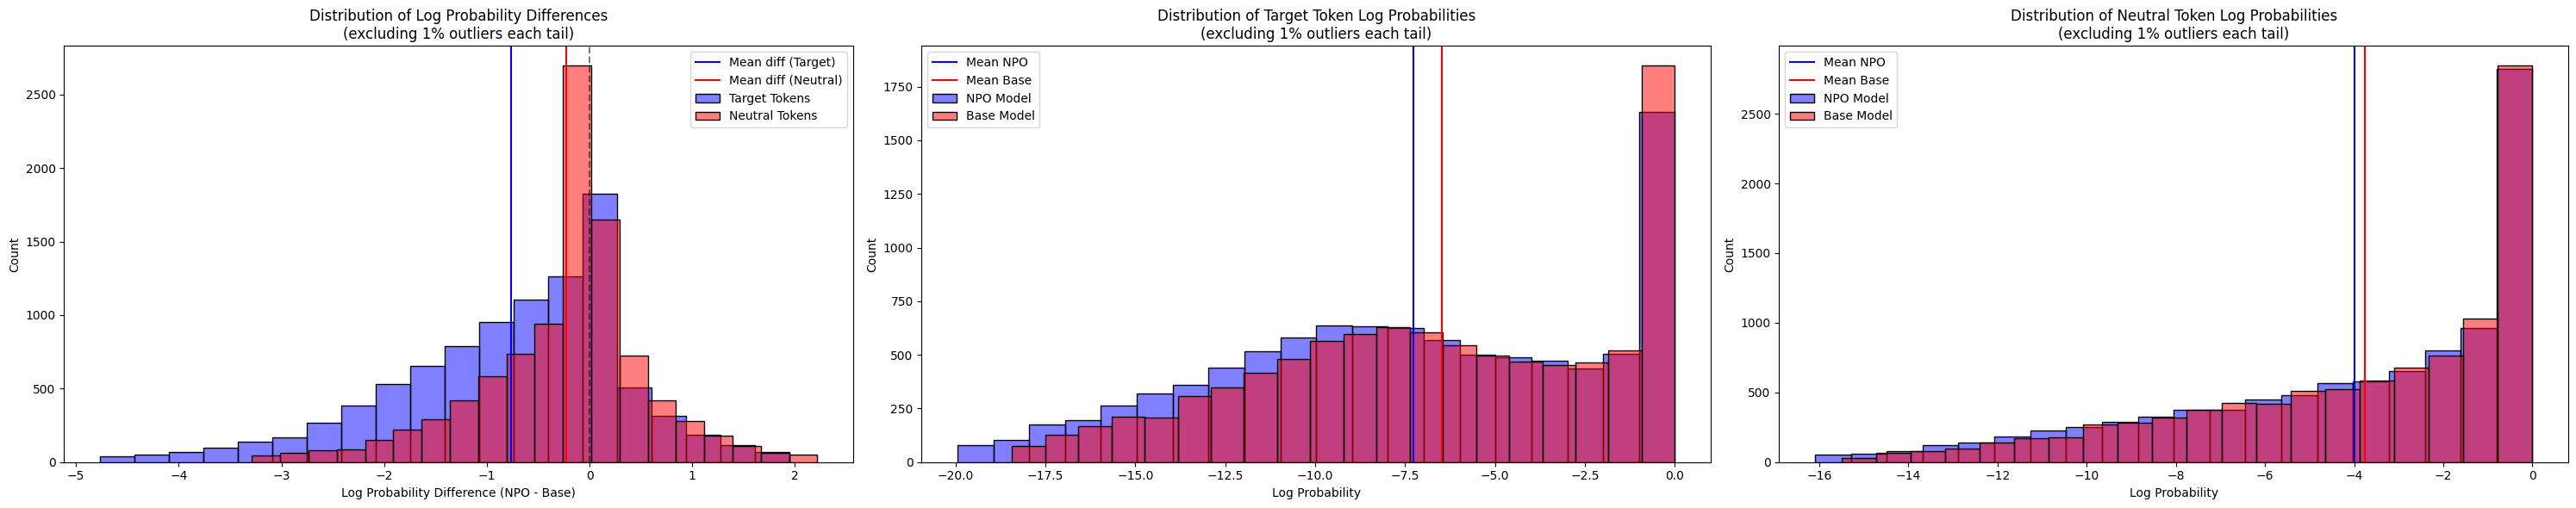

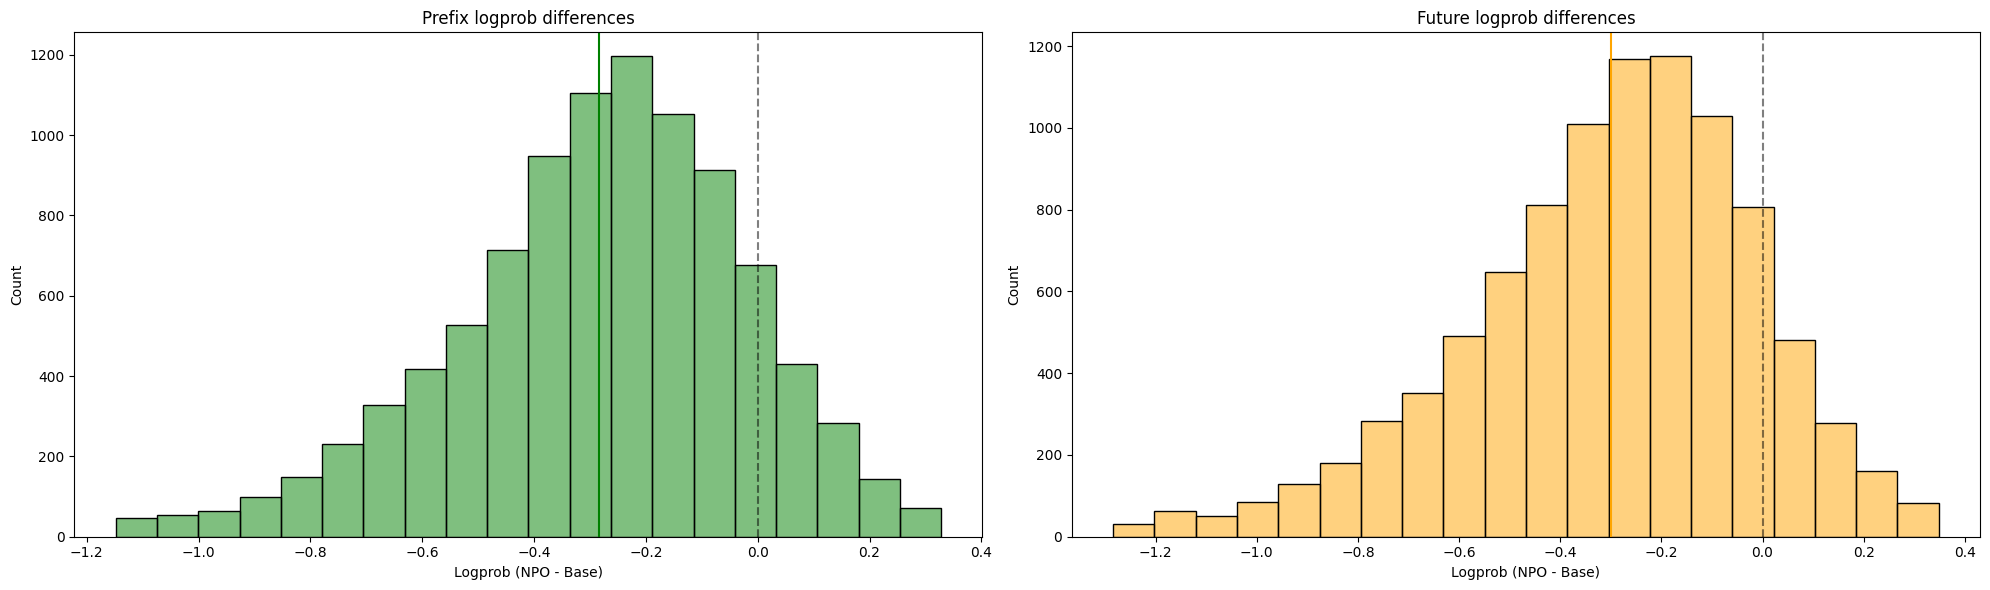

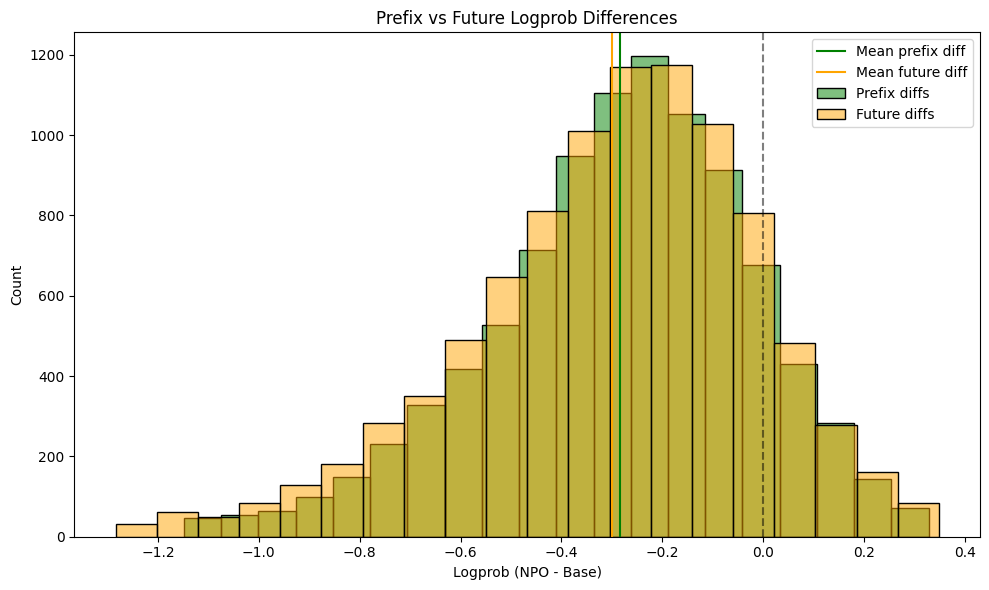

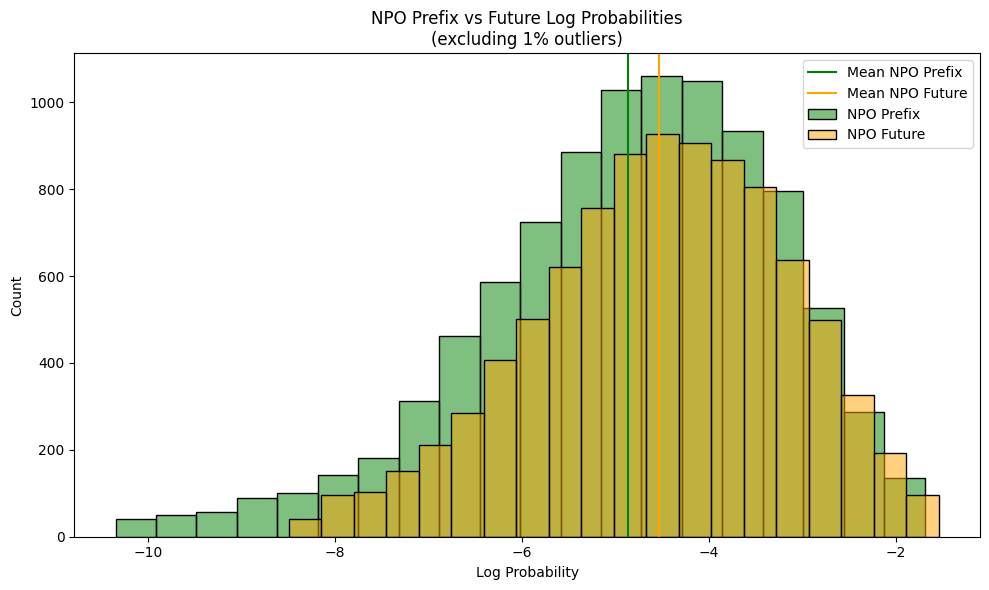

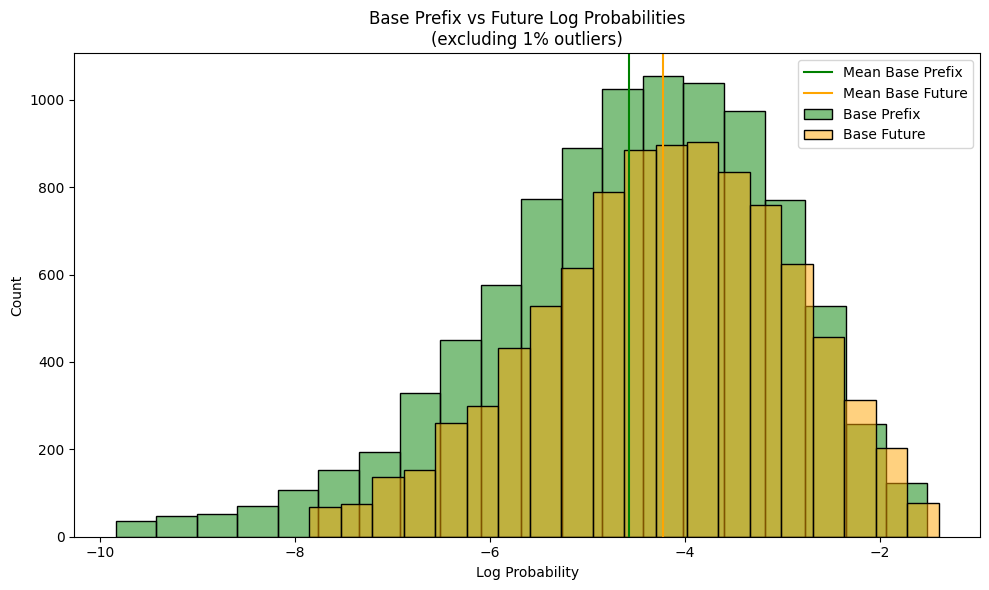


Basic statistics (after removing outliers):

Differences:
Target Tokens:
Mean diff: -0.766
Median diff: -0.546
Std diff: 1.124
% decreased: 77.2%
Samples: 9533 (removed 196)

Neutral Tokens:
Mean diff: -0.230
Median diff: -0.031
Std diff: 0.825
% decreased: 58.6%
Samples: 9800 (removed 200)

Raw Target Probabilities:
NPO Model:
Mean logprob: -7.276
Median logprob: -7.231
Std logprob: 5.207
Samples: 9533 (removed 196)

Base Model:
Mean logprob: -6.486
Median logprob: -6.399
Std logprob: 4.878
Samples: 9533 (removed 196)

Raw Neutral Probabilities:
NPO Model:
Mean logprob: -3.997
Median logprob: -2.822
Std logprob: 3.934
Samples: 9800

Base Model:
Mean logprob: -3.764
Median logprob: -2.616
Std logprob: 3.715
Samples: 9799

Prefix Probabilities:
NPO Model:
Mean logprob: -4.864
Median logprob: -4.692
Std logprob: 1.572
Samples: 9449

Base Model:
Mean logprob: -4.578
Median logprob: -4.419
Std logprob: 1.498
Samples: 9449

Future Probabilities:
NPO Model:
Mean logprob: -4.530
Median logpr

In [12]:
# %%
OUTLIER_PERCENTILE = 1

def remove_outliers(data, p):
    if not data:
        return data
    lower = np.percentile(data, p)
    upper = np.percentile(data, 100-p)
    return [x for x in data if lower <= x <= upper]

npo_logprobs_clean = remove_outliers(npo_token_logprobs, OUTLIER_PERCENTILE)
base_logprobs_clean = remove_outliers(base_token_logprobs, OUTLIER_PERCENTILE)
npo_neutral_clean = remove_outliers([n['token_logprob'] for n in neutral_npo if n['token_logprob']], OUTLIER_PERCENTILE)
base_neutral_clean = remove_outliers([b['token_logprob'] for b in neutral_base if b['token_logprob']], OUTLIER_PERCENTILE)
token_logprob_diffs_clean = remove_outliers(token_logprob_diffs, OUTLIER_PERCENTILE)
neutral_logprob_diffs_clean = remove_outliers(neutral_logprob_diffs, OUTLIER_PERCENTILE)
prefix_logprob_diffs_clean = remove_outliers(prefix_logprob_diffs, OUTLIER_PERCENTILE)
future_logprob_diffs_clean = remove_outliers(future_logprob_diffs, OUTLIER_PERCENTILE)

npo_prefix_clean = remove_outliers(npo_prefix_logprobs, OUTLIER_PERCENTILE)
base_prefix_clean = remove_outliers(base_prefix_logprobs, OUTLIER_PERCENTILE)
npo_future_clean = remove_outliers(npo_future_logprobs, OUTLIER_PERCENTILE)
base_future_clean = remove_outliers(base_future_logprobs, OUTLIER_PERCENTILE)

# Original plots retained
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
sns.histplot(x=token_logprob_diffs_clean, bins=20, ax=ax1, color='blue', alpha=0.5, label='Target Tokens')
sns.histplot(x=neutral_logprob_diffs_clean, bins=20, ax=ax1, color='red', alpha=0.5, label='Neutral Tokens')
ax1.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax1.axvline(np.mean(token_logprob_diffs_clean), color='blue', linestyle='-', label='Mean diff (Target)')
ax1.axvline(np.mean(neutral_logprob_diffs_clean), color='red', linestyle='-', label='Mean diff (Neutral)')
ax1.set_title(f'Distribution of Log Probability Differences\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax1.set_xlabel('Log Probability Difference (NPO - Base)')
ax1.legend()

sns.histplot(x=npo_logprobs_clean, bins=20, ax=ax2, color='blue', alpha=0.5, label='NPO Model')
sns.histplot(x=base_logprobs_clean, bins=20, ax=ax2, color='red', alpha=0.5, label='Base Model')
ax2.axvline(np.mean(npo_logprobs_clean), color='blue', linestyle='-', label='Mean NPO')
ax2.axvline(np.mean(base_logprobs_clean), color='red', linestyle='-', label='Mean Base')
ax2.set_title(f'Distribution of Target Token Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax2.set_xlabel('Log Probability')
ax2.legend()

sns.histplot(x=npo_neutral_clean, bins=20, ax=ax3, color='blue', alpha=0.5, label='NPO Model')
sns.histplot(x=base_neutral_clean, bins=20, ax=ax3, color='red', alpha=0.5, label='Base Model')
ax3.axvline(np.mean(npo_neutral_clean), color='blue', linestyle='-', label='Mean NPO')
ax3.axvline(np.mean(base_neutral_clean), color='red', linestyle='-', label='Mean Base')
ax3.set_title(f'Distribution of Neutral Token Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers each tail)')
ax3.set_xlabel('Log Probability')
ax3.legend()

plt.tight_layout()
plt.show()

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(x=prefix_logprob_diffs_clean, bins=20, ax=ax4, color='green', alpha=0.5)
ax4.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax4.axvline(np.mean(prefix_logprob_diffs_clean), color='green', linestyle='-')
ax4.set_title('Prefix logprob differences')
ax4.set_xlabel('Logprob (NPO - Base)')

sns.histplot(x=future_logprob_diffs_clean, bins=20, ax=ax5, color='orange', alpha=0.5)
ax5.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax5.axvline(np.mean(future_logprob_diffs_clean), color='orange', linestyle='-')
ax5.set_title('Future logprob differences')
ax5.set_xlabel('Logprob (NPO - Base)')

plt.tight_layout()
plt.show()

# New requested plots: prefix vs future diffs overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=prefix_logprob_diffs_clean, bins=20, ax=ax, color='green', alpha=0.5, label='Prefix diffs')
sns.histplot(x=future_logprob_diffs_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='Future diffs')
ax.axvline(0.0, color='black', linestyle='--', alpha=0.5)
ax.axvline(np.mean(prefix_logprob_diffs_clean), color='green', linestyle='-', label='Mean prefix diff')
ax.axvline(np.mean(future_logprob_diffs_clean), color='orange', linestyle='-', label='Mean future diff')
ax.set_title('Prefix vs Future Logprob Differences')
ax.set_xlabel('Logprob (NPO - Base)')
ax.legend()
plt.tight_layout()
plt.show()

# Raw prefix vs future for NPO overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=npo_prefix_clean, bins=20, ax=ax, color='green', alpha=0.5, label='NPO Prefix')
sns.histplot(x=npo_future_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='NPO Future')
ax.axvline(np.mean(npo_prefix_clean), color='green', linestyle='-', label='Mean NPO Prefix')
ax.axvline(np.mean(npo_future_clean), color='orange', linestyle='-', label='Mean NPO Future')
ax.set_title(f'NPO Prefix vs Future Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers)')
ax.set_xlabel('Log Probability')
ax.legend()
plt.tight_layout()
plt.show()

# Raw prefix vs future for Base overlaid
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=base_prefix_clean, bins=20, ax=ax, color='green', alpha=0.5, label='Base Prefix')
sns.histplot(x=base_future_clean, bins=20, ax=ax, color='orange', alpha=0.5, label='Base Future')
ax.axvline(np.mean(base_prefix_clean), color='green', linestyle='-', label='Mean Base Prefix')
ax.axvline(np.mean(base_future_clean), color='orange', linestyle='-', label='Mean Base Future')
ax.set_title(f'Base Prefix vs Future Log Probabilities\n(excluding {OUTLIER_PERCENTILE}% outliers)')
ax.set_xlabel('Log Probability')
ax.legend()
plt.tight_layout()
plt.show()

print("\nBasic statistics (after removing outliers):")
print("\nDifferences:")
print("Target Tokens:")
print(f"Mean diff: {np.mean(token_logprob_diffs_clean):.3f}")
print(f"Median diff: {np.median(token_logprob_diffs_clean):.3f}")
print(f"Std diff: {np.std(token_logprob_diffs_clean):.3f}")
print(f"% decreased: {(np.array(token_logprob_diffs_clean) < 0).mean()*100:.1f}%")
print(f"Samples: {len(token_logprob_diffs_clean)} (removed {len(token_logprob_diffs)-len(token_logprob_diffs_clean)})")

print("\nNeutral Tokens:")
print(f"Mean diff: {np.mean(neutral_logprob_diffs_clean):.3f}")
print(f"Median diff: {np.median(neutral_logprob_diffs_clean):.3f}")
print(f"Std diff: {np.std(neutral_logprob_diffs_clean):.3f}")
print(f"% decreased: {(np.array(neutral_logprob_diffs_clean) < 0).mean()*100:.1f}%")
print(f"Samples: {len(neutral_logprob_diffs_clean)} (removed {len(neutral_logprob_diffs)-len(neutral_logprob_diffs_clean)})")

print("\nRaw Target Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_logprobs_clean):.3f}")
print(f"Median logprob: {np.median(npo_logprobs_clean):.3f}")
print(f"Std logprob: {np.std(npo_logprobs_clean):.3f}")
print(f"Samples: {len(npo_logprobs_clean)} (removed {len(npo_token_logprobs)-len(npo_logprobs_clean)})")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_logprobs_clean):.3f}")
print(f"Median logprob: {np.median(base_logprobs_clean):.3f}")
print(f"Std logprob: {np.std(base_logprobs_clean):.3f}")
print(f"Samples: {len(base_logprobs_clean)} (removed {len(base_token_logprobs)-len(base_logprobs_clean)})")

print("\nRaw Neutral Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_neutral_clean):.3f}")
print(f"Median logprob: {np.median(npo_neutral_clean):.3f}")
print(f"Std logprob: {np.std(npo_neutral_clean):.3f}")
print(f"Samples: {len(npo_neutral_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_neutral_clean):.3f}")
print(f"Median logprob: {np.median(base_neutral_clean):.3f}")
print(f"Std logprob: {np.std(base_neutral_clean):.3f}")
print(f"Samples: {len(base_neutral_clean)}")

print("\nPrefix Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_prefix_clean):.3f}")
print(f"Median logprob: {np.median(npo_prefix_clean):.3f}")
print(f"Std logprob: {np.std(npo_prefix_clean):.3f}")
print(f"Samples: {len(npo_prefix_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_prefix_clean):.3f}")
print(f"Median logprob: {np.median(base_prefix_clean):.3f}")
print(f"Std logprob: {np.std(base_prefix_clean):.3f}")
print(f"Samples: {len(base_prefix_clean)}")

print("\nFuture Probabilities:")
print("NPO Model:")
print(f"Mean logprob: {np.mean(npo_future_clean):.3f}")
print(f"Median logprob: {np.median(npo_future_clean):.3f}")
print(f"Std logprob: {np.std(npo_future_clean):.3f}")
print(f"Samples: {len(npo_future_clean)}")

print("\nBase Model:")
print(f"Mean logprob: {np.mean(base_future_clean):.3f}")
print(f"Median logprob: {np.median(base_future_clean):.3f}")
print(f"Std logprob: {np.std(base_future_clean):.3f}")
print(f"Samples: {len(base_future_clean)}")


In [13]:
final_data = {
    "tokens": {
        token_id: {
            "token_text": tokenizer.decode([token_id]),
            "frequency_stats": {
                "ratio": ratio_freqs[token_id],
                "forget_freq": forget_freqs.get(token_id, 0),
                "retain_freq": retain_freqs.get(token_id, 0)
            },
            "snippets": snippets_data[token_id],  # Original snippets
            "logprobs": results[token_id]  # Use existing results
        }
        for token_id in high_ratio_tokens
    },
    "neutral": {
        "snippets": neutral_snippets,
        "logprobs": [
            {
                'npo_token_logprob': npo['token_logprob'],
                'base_token_logprob': base['token_logprob'],
                'npo_prefix_logprob': npo['prefix_logprob'],
                'base_prefix_logprob': base['prefix_logprob'],
                'npo_future_logprob': npo['future_logprob'],
                'base_future_logprob': base['future_logprob'],
                'token_logprob_diff': (npo['token_logprob'] - base['token_logprob'] 
                                     if npo['token_logprob'] and base['token_logprob'] else None)
            }
            for npo, base in zip(neutral_npo, neutral_base)
            if npo['token_logprob'] is not None and base['token_logprob'] is not None
        ]
    },
    "metadata": {
        "outlier_percentile": OUTLIER_PERCENTILE,
        "samples_per_token": SAMPLES_PER_TOKEN,
        "future_window": FUTURE_WINDOW,
        "prefix_window": PREFIX_WINDOW
    }
}

with open('perplexity_analysis.json', 'w') as f:
    json.dump(final_data, f, indent=2)